In [78]:
#Dual craft along side Collab

In [79]:
# Operational libraries
import os
import json

# Data manipulation libraries
import pandas as pd
import numpy as np
import math

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# LSTM model
from lstm_model import (
    prepare_data, 
    train_lstm_model, 
    plot_training_history, 
    evaluate_model, 
    plot_predictions, 
    calculate_rmse
)

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from cycle_gan import CycleGAN, preprocess_data, train_test_validation_split

# Install Tabulate for csv read and mod


In [80]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# <center> Anomoly Detection and Attribute Prediction utilizing Deep Learning Methods in multi-stage manufacturing. </center>


# Introduction ***

# Problem Statement ***


Data Source: https://www.kaggle.com/datasets/supergus/multistage-continuousflow-manufacturing-process/data


From the data set's card on it's Kaggle homepage:

Description of physical setup:


The data comes from a continuous flow process.

Sample rate is 1 Hz.

In the first stage, Machines 1, 2,  and 3 operate in parallel, and feed their outputs into a step that combines the flows.
Output from the combiner is measured in 15 locations. These measurements are the primary measurements to predict.
Next, the output flows into a second stage, where Machines 4 and 5 process in series.
Measurements are made again in the same 15 locations. These are the secondary measurements to predict.


Each measurement also has a target or Setpoint (setpoints are included in the first row of data).



Note on variable naming conventions:


* ~.C.Setpoint		Setpoint for Controlled variable

* ~.C.Actual		Actual value of Controlled variable

* ~.U.Actual		Actual value of Uncontrolled variable


Others		Environmental or raw material variables, States / events, etc.


\begin{equation*}
\begin{array}{ccl}
Start col &	End col	&	Description \\
0	&	0	&	Time stamp \\
1	&	2	&	Factory ambient conditions \\
3	&	6	&	First stage, Machine 1, raw material properties (material going in to Machine 1) \\
7	&	14	&	First stage, Machine 1 process variables \\
15	&	18	&	First stage, Machine 2, raw material properties (material going in to Machine 2) \\
19	&	26	&	First stage, Machine 2 process variables \\
27	&	30	&	First stage, Machine 3, raw material properties (material going in to Machine 3) \\
31	&	38	&	First stage, Machine 3 process variables \\
39	&	41	&	Combiner stage process parameters. Here we combines the outputs from Machines 1, 2, and 3. \\
42	&	71	&	PRIMARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each \\
72	&	78	&	Second stage, Machine 4 process variables \\
79	&	85	&	Second stage, Machine 5 process variables \\
86	&	115	&	SECONDARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each \\
\end{array}
\end{equation*}

# Describe the plan for my EDA and then model building


In [81]:
# Read in the manufacturing process data
factory_df = pd.read_csv('continuous_factory_process.csv')


In [82]:
# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
factory_df.info()

print("\nDataset Shape:")
print("-" * 50)
print(f"Rows: {factory_df.shape[0]}")
print(f"Columns: {factory_df.shape[1]}")

print("\nFirst few rows:")
print("-" * 50)
display(factory_df.head())

print("\nBasic Statistics:")
print("-" * 50)
display(factory_df.describe())

print("\nNumber of Columns with Missing Values:")
print("-" * 50)
print(f"Columns with missing values: {factory_df.isnull().any().sum()}")


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14088 entries, 0 to 14087
Columns: 116 entries, time_stamp to Stage2.Output.Measurement14.U.Setpoint
dtypes: float64(108), int64(7), object(1)
memory usage: 12.5+ MB

Dataset Shape:
--------------------------------------------------
Rows: 14088
Columns: 116

First few rows:
--------------------------------------------------


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71



Basic Statistics:
--------------------------------------------------


,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,...,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.00,14088.000000,1.408800e+04
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,...,7.535958e+00,7.930000e+00,5.416515e+00,5.650000e+00,1.972561e+00,1.850000e+00,3.535251e+00,2.89,7.515574,1.171000e+01
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,...,1.645785e+00,3.552840e-15,1.182333e+00,8.882099e-16,4.145398e-01,4.441050e-16,4.768244e-01,0.00,2.082948,1.776420e-15
min,13.840000,23.020000,11.540000,200.000000,601.110000,247.000000,231.300000,71.900000,71.300000,44.400000,...,-5.220420e-95,7.930000e+00,-2.703210e-95,5.650000e+00,-6.200020e-96,1.850000e+00,-1.822810e-95,2.89,-3.437021,1.171000e+01
25%,14.040000,23.530000,11.540000,200.000000,963.000000,247.000000,1257.170000,72.000000,71.600000,68.880000,...,7.840000e+00,7.930000e+00,5.560000e+00,5.650000e+00,2.030000e+00,1.850000e+00,3.450000e+00,2.89,7.720000,1.171000e+01
50%,15.120000,23.930000,11.540000,200.000000,963.000000,247.000000,1264.440000,72.000000,72.000000,71.980000,...,7.900000e+00,7.930000e+00,5.630000e+00,5.650000e+00,2.060000e+00,1.850000e+00,3.510000e+00,2.89,7.870000,1.171000e+01
75%,16.630000,24.160000,12.220000,201.000000,1027.430000,251.000000,1273.460000,72.000000,72.400000,72.920000,...,7.950000e+00,7.930000e+00,5.800000e+00,5.650000e+00,2.090000e+00,1.850000e+00,3.760000e+00,2.89,8.080000,1.171000e+01
max,17.240000,24.430000,12.900000,236.000000,1048.060000,257.000000,1331.820000,72.500000,72.700000,88.530000,...,8.590000e+00,7.930000e+00,6.320000e+00,5.650000e+00,5.200000e+00,1.850000e+00,8.000000e+00,2.89,14.260000,1.171000e+01



Number of Columns with Missing Values:
--------------------------------------------------
Columns with missing values: 0


describe the above...

... then candlestick graph

In [83]:
# Lets rename the columns
# Create a dictionary to store the old and new column names
column_mapping = {}

# Machine = Mchn
# Temperature = Temp
# Material = Mat
# Measurement = Meas
# Setpoint = Setp
# Actual = Act
# Controlled = Ctrl
# Uncontrolled = Unctrl
# Environmental = Env
# States = St

# Iterate through columns and create new names in temp dict
for column in factory_df.columns:
    if column != 'time_stamp':  # Keep timestamp column as is
        new_name = ''.join(' ' + c if c.isupper() else c for c in column)
        new_name = ''.join(' ' + c if c.isdigit() else c for c in new_name)
        new_name = new_name.replace('.', ' ')
        new_name = new_name.replace('Machine', 'Mchn')
        new_name = new_name.replace('Temperature', 'Temp') 
        new_name = new_name.replace('Material', 'Mat')
        new_name = new_name.replace('Measurement', 'Meas')
        new_name = new_name.replace('Setpoint', 'Setp')
        new_name = new_name.replace('Actual', 'Act')
        new_name = new_name.replace('Controlled', 'Ctrl')
        new_name = new_name.replace('Uncontrolled', 'Unctrl')
        new_name = new_name.replace('Environmental', 'Env')
        new_name = new_name.replace('States', 'St')
        new_name = new_name.replace('Output', 'Out')
        column_mapping[column] = new_name

# Rename the columns using the mapping
factory_df = factory_df.rename(columns=column_mapping)
factory_df.head()

,time_stamp,Ambient Conditions Ambient Humidity U Act,Ambient Conditions Ambient Temp U Act,Mchn 1 Raw Mat Property 1,Mchn 1 Raw Mat Property 2,Mchn 1 Raw Mat Property 3,Mchn 1 Raw Mat Property 4,Mchn 1 Raw Mat Feeder Parameter U Act,Mchn 1 Zone 1 Temp C Act,Mchn 1 Zone 2 Temp C Act,...,Stage 2 Out Meas 1 0 U Act,Stage 2 Out Meas 1 0 U Setp,Stage 2 Out Meas 1 1 U Act,Stage 2 Out Meas 1 1 U Setp,Stage 2 Out Meas 1 2 U Act,Stage 2 Out Meas 1 2 U Setp,Stage 2 Out Meas 1 3 U Act,Stage 2 Out Meas 1 3 U Setp,Stage 2 Out Meas 1 4 U Act,Stage 2 Out Meas 1 4 U Setp
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [84]:
# Lets iterate over each column to see if wer can spot any crazy outliers


# Calculate number of outliers (>3 std dev from mean) for each column
outlier_counts = {}
for column in factory_df.columns:
    if factory_df[column].dtype in ['float64', 'int64']:  # Only analyze numeric columns
        mean = factory_df[column].mean()
        std = factory_df[column].std()
        outliers = factory_df[column][(factory_df[column] < mean - 3*std) | 
                                    (factory_df[column] > mean + 3*std)]
        outlier_counts[column] = len(outliers)

# Convert to dataframe and sort by number of outliers
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', 
                                   columns=['Number of Outliers'])
outlier_df = outlier_df.sort_values('Number of Outliers', ascending=False)

print("\nNumber of outliers (>3 std dev) per column:")
print("-" * 50)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(outlier_df)



Number of outliers (>3 std dev) per column:
--------------------------------------------------


,Number of Outliers
Stage 2 Out Meas 0 U Act,1227
Stage 2 Out Meas 8 U Act,977
Stage 2 Out Meas 1 4 U Act,918
Stage 2 Out Meas 4 U Act,899
Stage 1 Out Meas 8 U Act,781
Stage 2 Out Meas 1 U Act,780
Stage 2 Out Meas 3 U Act,776
Stage 1 Out Meas 9 U Act,726
Stage 1 Out Meas 5 U Act,641
Stage 2 Out Meas 1 0 U Act,638


The majority of columns with values greater than 3 standard deviations are  Output variables, or in other words, the predictors. However while looking at this I realized that 3 standard deviations is a good method.... if the data is normally distributed. Let's try and inspect the distributions of each.


In [85]:
# Initialize dataframe for statistics
factory_summary = pd.DataFrame()

# Seperate Time Column
sub_factory_df = factory_df.drop('time_stamp', axis = 1)

# Iterate through the columns calculating our stats
for column in sub_factory_df.columns:
    if sub_factory_df[column].dtype in ['float64', 'int64']:
        factory_summary.loc[column, 'Mean'] = sub_factory_df[column].mean()
        factory_summary.loc[column, 'Std Dev'] = sub_factory_df[column].std()
        factory_summary.loc[column, 'Skewness'] = sub_factory_df[column].skew()
        factory_summary.loc[column, 'Kurtosis'] = sub_factory_df[column].kurt()
        factory_summary.loc[column, 'IQR'] = sub_factory_df[column].quantile(0.75) - sub_factory_df[column].quantile(0.25)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(factory_summary)

# Save factory summary statistics to CSV
factory_summary.to_csv('factory_summary_statistics.csv')


,Mean,Std Dev,Skewness,Kurtosis,IQR
Ambient Conditions Ambient Humidity U Act,15.330759,1.188993e+00,0.113315,-1.639747,2.5900
Ambient Conditions Ambient Temp U Act,23.843635,3.735350e-01,-0.532854,-0.688510,0.6300
Mchn 1 Raw Mat Property 1,11.851256,5.103091e-01,1.162976,-0.413131,0.6800
Mchn 1 Raw Mat Property 2,205.676320,1.160632e+01,1.921282,2.187776,1.0000
Mchn 1 Raw Mat Property 3,951.679815,1.266620e+02,-2.220318,3.485070,64.4300
Mchn 1 Raw Mat Property 4,248.868896,3.297820e+00,1.596464,1.190369,4.0000
Mchn 1 Raw Mat Feeder Parameter U Act,1242.764276,9.584595e+01,-4.487157,22.806924,16.2900
Mchn 1 Zone 1 Temp C Act,72.013330,6.318299e-02,4.160693,23.209066,0.0000
Mchn 1 Zone 2 Temp C Act,72.013106,4.063128e-01,0.029851,-1.393234,0.8000
Mchn 1 Motor Amperage U Act,70.333111,5.525217e+00,-1.587474,4.663747,4.0400


In [86]:
df = pd.read_csv('factory_summary_statistics.csv')
df['Unnamed: 0'] = df['Unnamed: 0'].astype(str)

# Melt the dataframe to long format
df_melted = df.melt(id_vars='Unnamed: 0', value_vars=['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'IQR'])

# Rename the columns
df_melted.columns = ['Statistic', 'Measure', 'Value']

# Print the first 5 rows of the dataframe
print(df_melted.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column name and their data types
print(df_melted.info())


| Statistic                                    | Measure   | Value   |
|:---------------------------------------------|:----------|:--------|
| Ambient Conditions  Ambient Humidity  U  Act | Mean      | 15.3308 |
| Ambient Conditions  Ambient Temp  U  Act     | Mean      | 23.8436 |
| Mchn 1  Raw Mat  Property 1                  | Mean      | 11.8513 |
| Mchn 1  Raw Mat  Property 2                  | Mean      | 205.676 |
| Mchn 1  Raw Mat  Property 3                  | Mean      | 951.68  |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Statistic  575 non-null    object 
 1   Measure    575 non-null    object 
 2   Value      575 non-null    float64
dtypes: float64(1), object(2)
memory usage: 13.6+ KB
None


In [87]:
alt.renderers.enable('jupyterlab')
chart = alt.Chart(df_melted).mark_rect().encode(
    # Set `Measure` on the x-axis and `Statistic` on the y-axis
    x=alt.X('Measure', title='Measure'),
    y=alt.Y('Statistic', title='Statistic'),
    # Use `Value` for color intensity
    color=alt.Color('Value', title='Value'),
    # Add tooltips for each column
    tooltip=['Measure', 'Statistic', 'Value']
).properties(
    # Set the title of the chart
    title='Distribution of Summary Statistics'
).interactive()  # Make the chart interactive
display(chart)
# Save the chart as a JSON file
chart.save('distribution_heatmap.json', renderer = 'notebook')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# LSTM Helper Functions

In [88]:
def create_sequences(data, seq_length, output_cols):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Get sequence of features
        seq = data.iloc[i:i+seq_length].values
        # Get target (next time step values for output measurements)
        target = data.iloc[i+seq_length][output_cols].values
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [89]:
def prepare_data(train_df, test_df, seq_length=60):
    """
    Prepare data for LSTM model
    
    Parameters:
    -----------
    train_df : pandas DataFrame
        Training data
    test_df : pandas DataFrame
        Testing data
    seq_length : int
        Sequence length for LSTM input
        
    Returns:
    --------
    X_train, y_train, X_test, y_test, scaler, output_cols, output_indices
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Convert timestamp to datetime and set as index if not already done
    if 'time_stamp' in train_df.columns:
        train_df['time_stamp'] = pd.to_datetime(train_df['time_stamp'])
        train_df.set_index('time_stamp', inplace=True)
        test_df['time_stamp'] = pd.to_datetime(test_df['time_stamp'])
        test_df.set_index('time_stamp', inplace=True)

    # Select both Stage 1 and Stage 2 output measurements
    output_cols = [col for col in train_df.columns if 
                   (('Stage 1' in col or 'Stage 2' in col) and 'Out' in col and 'Act' in col)]
    
    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
    test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)
    
    # Create sequences for LSTM
    X_train, y_train = create_sequences(train_scaled, seq_length, output_cols)
    X_test, y_test = create_sequences(test_scaled, seq_length, output_cols)
    
    # Get the indices of output columns in the original dataframe
    output_indices = [train_df.columns.get_loc(col) for col in output_cols]
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, scaler, output_cols, output_indices

In [90]:
def plot_predictions(y_test_inv, pred_inv, output_cols, n_samples=100, n_features=5):
    """
    Plot predictions vs actual values
    
    Parameters:
    -----------
    y_test_inv : numpy array
        Inverse transformed actual values
    pred_inv : numpy array
        Inverse transformed predictions
    output_cols : list
        Names of output columns
    n_samples : int
        Number of samples to plot
    n_features : int
        Number of features to plot
    """
    plt.figure(figsize=(15, 10))
    for i in range(min(n_features, len(output_cols))):
        plt.subplot(n_features, 1, i+1)
        plt.plot(y_test_inv[:n_samples, i], label='Actual')
        plt.plot(pred_inv[:n_samples, i], label='Predicted')
        plt.title(f'Predictions for {output_cols[i]}')
        plt.legend()
    plt.tight_layout()
    plt.show()



In [91]:
def calculate_rmse(y_test_inv, pred_inv, output_cols):
    """
    Calculate RMSE for each output feature
    
    Parameters:
    -----------
    y_test_inv : numpy array
        Inverse transformed actual values
    pred_inv : numpy array
        Inverse transformed predictions
    output_cols : list
        Names of output columns
    """
    print("Root Mean Squared Error (RMSE) for each output feature:")
    for i, col in enumerate(output_cols):
        rmse = math.sqrt(mean_squared_error(y_test_inv[:, i], pred_inv[:, i]))
        print(f"{col}: {rmse:.4f}")
    
    # Calculate overall RMSE
    overall_rmse = math.sqrt(mean_squared_error(y_test_inv, pred_inv))
    print(f"\nOverall RMSE: {overall_rmse:.4f}")

# Example usage:
"""
# Assuming train_df and test_df are already defined
X_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df)

# Get input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_shape = y_train.shape[1]  # Number of output features

# Train the model
lstm_model, history = train_lstm_model(X_train, y_train, input_shape, output_shape)

# Plot training history
plot_training_history(history)

# Evaluate the model
y_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)

# Plot predictions
plot_predictions(y_test_inv, pred_inv, output_cols)

# Calculate RMSE
calculate_rmse(y_test_inv, pred_inv, output_cols)
""" 

'\n# Assuming train_df and test_df are already defined\nX_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df)\n\n# Get input and output shapes\ninput_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)\noutput_shape = y_train.shape[1]  # Number of output features\n\n# Train the model\nlstm_model, history = train_lstm_model(X_train, y_train, input_shape, output_shape)\n\n# Plot training history\nplot_training_history(history)\n\n# Evaluate the model\ny_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)\n\n# Plot predictions\nplot_predictions(y_test_inv, pred_inv, output_cols)\n\n# Calculate RMSE\ncalculate_rmse(y_test_inv, pred_inv, output_cols)\n'

In [92]:
def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    -----------
    history : Keras history object
        Training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Data Split

In [93]:
# Now we split out data into a trianing and testing batch
# Split the data into training and testing sets (80-20 split)
train_size = int(0.8 * len(factory_df))
train_df = factory_df[:train_size]
test_df = factory_df[train_size:]

print(f"Training set size: {len(train_df)} samples")
print(f"Testing set size: {len(test_df)} samples")


Training set size: 11270 samples
Testing set size: 2818 samples


Prepare for the Long Short Term Mermory

In [94]:
# Prepare data for LSTM
print("Preparing data for LSTM...")
X_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df, seq_length=60)

# Get input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_shape = y_train.shape[1]  # Number of output features

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")
print(f"Number of output features: {len(output_cols)}")
print(f"Output features: {output_cols[:3]}...")  # Show first 3 output features


Preparing data for LSTM...
X_train shape: (11210, 60, 115)
y_train shape: (11210, 30)
X_test shape: (2758, 60, 115)
y_test shape: (2758, 30)
Input shape: (60, 115)
Output shape: 30
Number of output features: 30
Output features: [' Stage 1  Out  Meas 0  U  Act', ' Stage 1  Out  Meas 1  U  Act', ' Stage 1  Out  Meas 2  U  Act']...


# Set up the architecture and Create model functions

In [95]:
def create_lstm_model(input_shape, output_shape):
    """
    Create a simple LSTM model
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (sequence_length, num_features)
    output_shape : int
        Number of output features
        
    Returns:
    --------
    Compiled Keras model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    
    # Second LSTM layer
    model.add(LSTM(32, activation='relu'))
    
    # Dropout for regularization
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Dense hidden layer
    model.add(Dense(32, activation='relu'))
    
    # Output layer
    model.add(Dense(output_shape))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

# Train  and Validate Functions

In [96]:
def train_lstm_model(X_train, y_train, input_shape, output_shape, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    -----------
    X_train : numpy array
        Training input data
    y_train : numpy array
        Training target data
    input_shape : tuple
        Shape of input data (sequence_length, num_features)
    output_shape : int
        Number of output features
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
        
    Returns:
    --------
    Trained model and training history
    """
    # Create model
    lstm_model = create_lstm_model(input_shape, output_shape)
    lstm_model.summary()
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
    
    # Train the model
    history = lstm_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return lstm_model, history

In [97]:
def evaluate_model(model, X_test, y_test, scaler, output_indices):
    """
    Evaluate the model on test data
    
    Parameters:
    -----------
    model : Keras model
        Trained LSTM model
    X_test : numpy array
        Test input data
    y_test : numpy array
        Test target data
    scaler : sklearn scaler
        Fitted scaler for inverse transformation
    output_indices : list
        Indices of output columns in the original dataframe
    """
    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_test_inv = inverse_transform_output(y_test, output_indices, scaler)
    pred_inv = inverse_transform_output(predictions, output_indices, scaler)
    
    return y_test_inv, pred_inv

In [98]:
def inverse_transform_output(scaled_data, output_indices, scaler):
    """
    Inverse transform the scaled data for specific columns
    
    Parameters:
    -----------
    scaled_data : numpy array
        Scaled data to inverse transform
    output_indices : list
        Indices of output columns in the original dataframe
    scaler : sklearn scaler
        Fitted scaler for inverse transformation
        
    Returns:
    --------
    Inverse transformed data
    """
    # Get the number of features in the original data
    n_features = len(scaler.scale_)
    
    # Create a dummy array of zeros with the same shape as the original data
    dummy = np.zeros((scaled_data.shape[0], n_features))
    
    # Place the scaled output data in the correct columns
    for i, idx in enumerate(output_indices):
        dummy[:, idx] = scaled_data[:, i]
        
    # Inverse transform
    dummy_inversed = scaler.inverse_transform(dummy)
    
    # Extract only the output columns
    return dummy_inversed[:, output_indices]

In [99]:
# Train the model
print("\nTraining LSTM model...")
lstm_model, history = train_lstm_model(
    X_train, y_train, 
    input_shape, output_shape, 
    epochs=20,  # Reduced for demonstration
    batch_size=32
)


Training LSTM model...


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,542 (236.49 KB)

 Trainable params: 60,542 (236.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1356 - mae: 0.2645 - val_loss: 0.0357 - val_mae: 0.1192
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0204 - mae: 0.0920 - val_loss: 0.0308 - val_mae: 0.1073
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0148 - mae: 0.0721 - val_loss: 0.0294 - val_mae: 0.0883
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0124 - mae: 0.0609 - val_loss: 0.0294 - val_mae: 0.0888
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0113 - mae: 0.0558 - val_loss: 0.0294 - val_mae: 0.0818
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0106 - mae: 0.0527 - val_loss: 0.0294 - val_mae: 0.0756
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0100 - mae: 0.0503 - val_loss: 0.0299 - val_mae: 0.0748
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0093 - mae: 0.0472 - val_loss: 0.0299 - val_mae: 0.0773
Epoch 9/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms


Plotting training history...


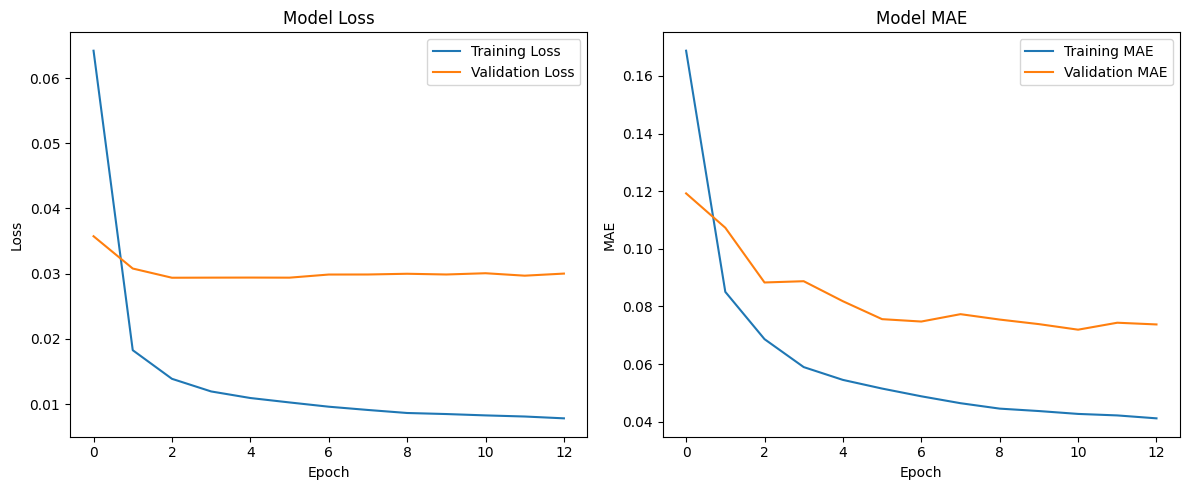

In [100]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)


In [101]:

# Evaluate the model
print("\nEvaluating model on test data...")
y_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)




Evaluating model on test data...
Test Loss: 0.0407
Test MAE: 0.1045
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step



Plotting predictions vs actual values...


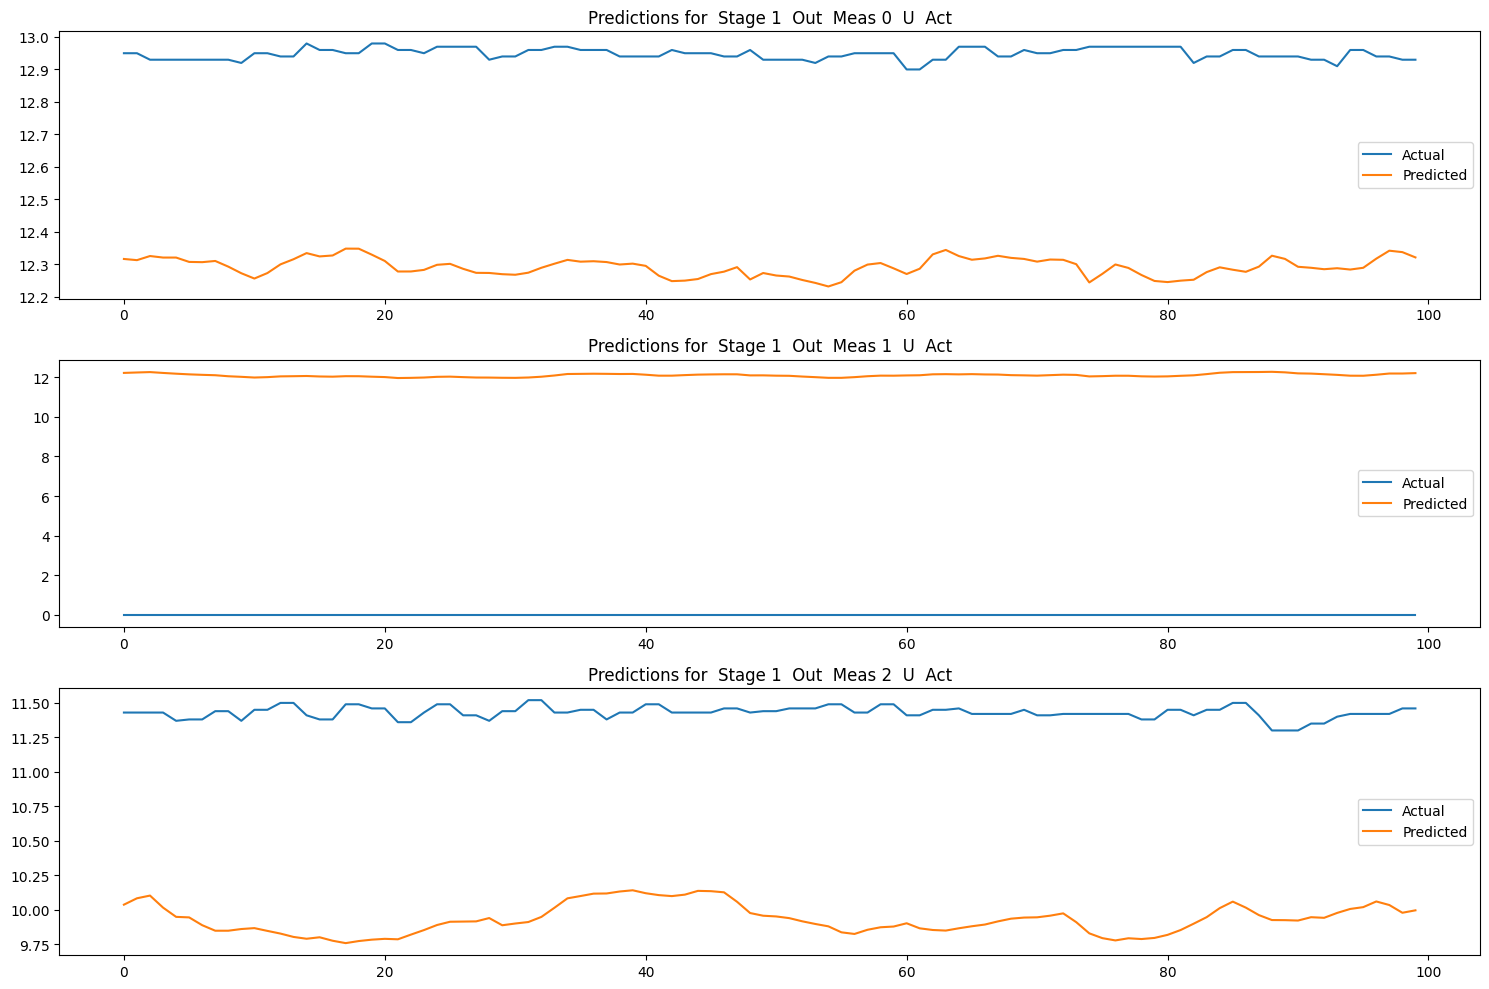

In [102]:
# Plot predictions
print("\nPlotting predictions vs actual values...")
plot_predictions(y_test_inv, pred_inv, output_cols, n_samples=100, n_features=3)


In [103]:

# Calculate RMSE
print("\nCalculating RMSE for each output feature...")
calculate_rmse(y_test_inv, pred_inv, output_cols)

print("\nLSTM model training and evaluation complete!") 


Calculating RMSE for each output feature...
Root Mean Squared Error (RMSE) for each output feature:
 Stage 1  Out  Meas 0  U  Act: 0.3729
 Stage 1  Out  Meas 1  U  Act: 12.8907
 Stage 1  Out  Meas 2  U  Act: 1.1134
 Stage 1  Out  Meas 3  U  Act: 0.6958
 Stage 1  Out  Meas 4  U  Act: 5.3327
 Stage 1  Out  Meas 5  U  Act: 0.5044
 Stage 1  Out  Meas 6  U  Act: 1.0931
 Stage 1  Out  Meas 7  U  Act: 0.3652
 Stage 1  Out  Meas 8  U  Act: 3.2787
 Stage 1  Out  Meas 9  U  Act: 3.2645
 Stage 1  Out  Meas 1 0  U  Act: 0.2408
 Stage 1  Out  Meas 1 1  U  Act: 0.4353
 Stage 1  Out  Meas 1 2  U  Act: 0.0913
 Stage 1  Out  Meas 1 3  U  Act: 0.7531
 Stage 1  Out  Meas 1 4  U  Act: 7.0006
 Stage 2  Out  Meas 0  U  Act: 2.1571
 Stage 2  Out  Meas 1  U  Act: 0.9941
 Stage 2  Out  Meas 2  U  Act: 1.4338
 Stage 2  Out  Meas 3  U  Act: 0.6108
 Stage 2  Out  Meas 4  U  Act: 6.3579
 Stage 2  Out  Meas 5  U  Act: 0.5077
 Stage 2  Out  Meas 6  U  Act: 0.1929
 Stage 2  Out  Meas 7  U  Act: 0.1802
 Stage 2  Out 

In [104]:
def calculate_normalized_errors(y_true, y_pred):
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Calculate NRMSE (normalized by the range of the true values)
    nrmse_range = rmse / (np.max(y_true) - np.min(y_true))
    
    # Calculate NRMSE (normalized by the mean of the true values)
    nrmse_mean = rmse / np.mean(y_true)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Adding small epsilon to avoid division by zero
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    return {
        'rmse': rmse,
        'nrmse_range': nrmse_range,
        'nrmse_mean': nrmse_mean,
        'mape': mape
    }

In [105]:
y_pred = lstm_model.predict(X_test)  # Assuming X_test is your test input data

# For each output feature
normalized_metrics = {}
# Assuming y_test and y_pred are numpy arrays with shape (n_samples, n_features)
n_features = y_test.shape[1]  # Get number of features

for i in range(n_features):
    feature_name = f"Feature_{i}"  # Or use your actual feature names if you have them
    metrics = calculate_normalized_errors(
        y_test[:, i],
        y_pred[:, i]
    )
    normalized_metrics[feature_name] = metrics

# Print results
for feature, metrics in normalized_metrics.items():
    print(f"\nMetrics for {feature}:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"NRMSE (range): {metrics['nrmse_range']:.4f} - Error relative to data range")
    print(f"NRMSE (mean): {metrics['nrmse_mean']:.4f} - Error relative to mean value")
    print(f"MAPE: {metrics['mape']:.2f}% - Average percentage error")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Metrics for Feature_0:
RMSE: 0.0179
NRMSE (range): 0.7611 - Error relative to data range
NRMSE (mean): 0.0289 - Error relative to mean value
MAPE: 2.32% - Average percentage error

Metrics for Feature_1:
RMSE: 0.5788
NRMSE (range): 0.7043 - Error relative to data range
NRMSE (mean): 3.4642 - Error relative to mean value
MAPE: 402.54% - Average percentage error

Metrics for Feature_2:
RMSE: 0.0391
NRMSE (range): 0.2530 - Error relative to data range
NRMSE (mean): 0.0685 - Error relative to mean value
MAPE: 6.52% - Average percentage error

Metrics for Feature_3:
RMSE: 0.0265
NRMSE (range): 1.1597 - Error relative to data range
NRMSE (mean): 0.0323 - Error relative to mean value
MAPE: 2.56% - Average percentage error

Metrics for Feature_4:
RMSE: 0.1536
NRMSE (range): 0.1256 - Error relative to data range
NRMSE (mean): 0.1588 - Error relative to mean value
MAPE: 16480844712.12% - Average percentage error

Metrics for Feature_5:
RMSE: 0.0913
NRMSE (

C:\Users\micha\AppData\Local\Temp\ipykernel_17712\105450877.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_range = rmse / (np.max(y_true) - np.min(y_true))


# Prepare for cycle Gan


In [106]:

# Configuration parameters
EPOCHS = 100
BATCH_SIZE = 64
GEN_LEARNING_RATE = 0.0002
DISC_LEARNING_RATE = 0.0002
GEN_HIDDEN_LAYERS = [256, 128, 64]
DISC_HIDDEN_LAYERS = [64, 32, 16]
GEN_DROPOUT_RATE = 0.2
DISC_DROPOUT_RATE = 0.3
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 1.0
VALIDATE_EVERY = 5
SAMPLE_INTERVAL = 5
SAVE_MODEL_INTERVAL = 20


In [107]:

def load_and_prepare_data(file_path='continuous_factory_process.csv'):
    """
    Load the manufacturing data and prepare it for the CycleGAN
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file with manufacturing data
    
    Returns:
    --------
    tuple : (X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, X_test, stage1_test, stage2_test, scalers)
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Extract Stage 1 (primary output) measurement columns
    stage1_actual_cols = [col for col in df.columns if 'Stage1.Output.Measurement' in col and '.U.Actual' in col]
    
    # Extract Stage 2 (secondary output) measurement columns
    stage2_actual_cols = [col for col in df.columns if 'Stage2.Output.Measurement' in col and '.U.Actual' in col]
    
    print(f"Found {len(stage1_actual_cols)} Stage 1 measurement columns")
    print(f"Found {len(stage2_actual_cols)} Stage 2 measurement columns")
    
    # Filter out the time_stamp column from input features
    input_cols = [col for col in df.columns if col not in stage1_actual_cols + stage2_actual_cols and col != 'time_stamp']
    
    print(f"Using {len(input_cols)} columns as input features")
    
    # Preprocess the data
    X_scaled, stage1_scaled, stage2_scaled, scalers = preprocess_data(
        df, stage1_actual_cols, stage2_actual_cols, input_cols
    )
    
    print("Data preprocessing complete")
    print(f"Input shape: {X_scaled.shape}")
    print(f"Stage 1 shape: {stage1_scaled.shape}")
    print(f"Stage 2 shape: {stage2_scaled.shape}")
    
    # Split into train, validation, and test sets
    data_splits = train_test_validation_split(
        X_scaled, stage1_scaled, stage2_scaled, 
        test_size=0.15, 
        val_size=0.15
    )
    
    # Save column information for later use
    column_info = {
        'input_cols': input_cols,
        'stage1_cols': stage1_actual_cols,
        'stage2_cols': stage2_actual_cols
    }
    
    with open('column_info.json', 'w') as f:
        json.dump(column_info, f)
    
    print("Data split complete")
    print(f"Train set size: {data_splits[0].shape[0]}")
    print(f"Validation set size: {data_splits[3].shape[0]}")
    print(f"Test set size: {data_splits[6].shape[0]}")
    
    return data_splits + (scalers,)


In [108]:

def train_cyclegan(data_splits, input_dims, hyperparameters=None):
    """
    Train the CycleGAN model with the provided data
    
    Parameters:
    -----------
    data_splits : tuple
        The data splits from train_test_validation_split 
    input_dims : int
        Dimension of the input features
    hyperparameters : dict, optional
        Dictionary of hyperparameters to override defaults
        
    Returns:
    --------
    CycleGAN : The trained CycleGAN model
    """
    # Unpack the data splits
    X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, X_test, stage1_test, stage2_test = data_splits
    
    # Apply hyperparameters if provided
    params = {
        'gen_hidden_layers': GEN_HIDDEN_LAYERS,
        'disc_hidden_layers': DISC_HIDDEN_LAYERS,
        'gen_dropout_rate': GEN_DROPOUT_RATE,
        'disc_dropout_rate': DISC_DROPOUT_RATE,
        'gen_learning_rate': GEN_LEARNING_RATE,
        'disc_learning_rate': DISC_LEARNING_RATE,
        'lambda_cycle': LAMBDA_CYCLE,
        'lambda_identity': LAMBDA_IDENTITY
    }
    
    if hyperparameters:
        params.update(hyperparameters)
    
    # Log the hyperparameters
    print("Training with hyperparameters:")
    for k, v in params.items():
        print(f"- {k}: {v}")
    
    # Create the model
    model = CycleGAN(
        input_dims=input_dims,
        stage1_dims=stage1_train.shape[1],
        stage2_dims=stage2_train.shape[1],
        **params
    )
    
    # Create a model directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Train the model
    print(f"Starting training for {EPOCHS} epochs with batch size {BATCH_SIZE}...")
    model.train(
        input_features=X_train,
        stage1_measurements=stage1_train,
        stage2_measurements=stage2_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validate_every=VALIDATE_EVERY,
        sample_interval=SAMPLE_INTERVAL,
        save_model_interval=SAVE_MODEL_INTERVAL,
        validation_data=(X_val, stage1_val, stage2_val)
    )
    
    # Save the final model
    model.save_models('models/cyclegan_final')
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_metrics = model.evaluate_model(X_test, stage1_test, stage2_test)
    
    # Print and save test metrics
    print("Test set metrics:")
    for metric, value in test_metrics.items():
        print(f"- {metric}: {value:.4f}")
    
    with open('models/test_metrics.json', 'w') as f:
        json.dump(test_metrics, f)
    
    # Plot training history
    model.plot_history()
    
    return model


In [109]:

def hyperparameter_tuning(data_splits, input_dims, param_grid):
    """
    Simple hyperparameter tuning for the CycleGAN model
    
    Parameters:
    -----------
    data_splits : tuple
        The data splits from train_test_validation_split
    input_dims : int
        Dimension of the input features
    param_grid : dict
        Dictionary of hyperparameter options to try
        
    Returns:
    --------
    tuple : (best_params, best_metrics)
    """
    X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, _, _, _ = data_splits
    
    # Use a small subset for faster tuning
    subset_size = min(1000, X_train.shape[0])
    idx = np.random.choice(X_train.shape[0], subset_size, replace=False)
    X_subset = X_train[idx]
    stage1_subset = stage1_train[idx]
    stage2_subset = stage2_train[idx]
    
    # Track best parameters and performance
    best_params = None
    best_metrics = None
    best_loss = float('inf')
    
    # Create a directory for tuning results
    os.makedirs('tuning_results', exist_ok=True)
    
    # Simple grid search over parameters
    tuning_results = []
    
    for i, params in enumerate(param_grid):
        print(f"Tuning configuration {i+1}/{len(param_grid)}")
        print(f"Parameters: {params}")
        
        # Create and train model with current params
        model = CycleGAN(
            input_dims=input_dims,
            stage1_dims=stage1_train.shape[1],
            stage2_dims=stage2_train.shape[1],
            **params
        )
        
        # Train for a limited number of epochs
        model.train(
            input_features=X_subset,
            stage1_measurements=stage1_subset,
            stage2_measurements=stage2_subset,
            epochs=20,  # Short training for tuning
            batch_size=64,
            validate_every=5,
            sample_interval=10,
            save_model_interval=999,  # Don't save during tuning
            validation_data=(X_val, stage1_val, stage2_val)
        )
        
        # Evaluate on validation set
        metrics = model.evaluate_model(X_val, stage1_val, stage2_val)
        
        # Save this configuration and its results
        result = {
            'params': params,
            'metrics': metrics,
            'total_loss': metrics['stage1_mae'] + metrics['stage2_mae'] + 0.5 * metrics['cycle_s1_mae'] + 0.5 * metrics['cycle_s2_mae']
        }
        tuning_results.append(result)
        
        # Check if this is the best configuration
        if result['total_loss'] < best_loss:
            best_loss = result['total_loss']
            best_params = params
            best_metrics = metrics
            
        # Save intermediate results
        with open(f'tuning_results/tuning_results_{i}.json', 'w') as f:
            json.dump(result, f)
    
    # Save all tuning results
    with open('tuning_results/all_tuning_results.json', 'w') as f:
        json.dump(tuning_results, f)
        
    print("Hyperparameter tuning complete")
    print(f"Best parameters: {best_params}")
    print(f"Best metrics: {best_metrics}")
    
    return best_params, best_metrics

if __name__ == "__main__":
    # Load and prepare data
    data_splits_with_scalers = load_and_prepare_data()
    data_splits = data_splits_with_scalers[:-1]  # Extract just the data splits
    scalers = data_splits_with_scalers[-1]      # Extract the scalers
    
    # Get input dimensions
    input_dims = data_splits[0].shape[1]
    
    # Train the model with default hyperparameters
    print("Training CycleGAN with default hyperparameters...")
    model = train_cyclegan(data_splits, input_dims)
    
    # Uncomment to run hyperparameter tuning
    """
    print("Starting hyperparameter tuning...")
    param_grid = [
        {
            'gen_hidden_layers': [256, 128, 64],
            'disc_hidden_layers': [64, 32, 16],
            'gen_dropout_rate': 0.2,
            'disc_dropout_rate': 0.3,
            'gen_learning_rate': 0.0002,
            'disc_learning_rate': 0.0002,
            'lambda_cycle': 10.0,
            'lambda_identity': 1.0
        },
        {
            'gen_hidden_layers': [512, 256, 128],
            'disc_hidden_layers': [128, 64, 32],
            'gen_dropout_rate': 0.3,
            'disc_dropout_rate': 0.4,
            'gen_learning_rate': 0.0001,
            'disc_learning_rate': 0.0001,
            'lambda_cycle': 15.0,
            'lambda_identity': 0.5
        },
        {
            'gen_hidden_layers': [128, 64],
            'disc_hidden_layers': [32, 16],
            'gen_dropout_rate': 0.1,
            'disc_dropout_rate': 0.2,
            'gen_learning_rate': 0.0005,
            'disc_learning_rate': 0.0005,
            'lambda_cycle': 5.0,
            'lambda_identity': 2.0
        }
    ]
    
    best_params, best_metrics = hyperparameter_tuning(data_splits, input_dims, param_grid)
    
    # Train final model with best parameters
    print("Training final model with best hyperparameters...")
    model = train_cyclegan(data_splits, input_dims, best_params)
    """
    
    print("CycleGAN training complete!") 

Loading data from continuous_factory_process.csv...


Found 15 Stage 1 measurement columns
Found 15 Stage 2 measurement columns
Using 85 columns as input features
Data preprocessing complete
Input shape: (14088, 85)
Stage 1 shape: (14088, 15)
Stage 2 shape: (14088, 15)
Data split complete
Train set size: 9860
Validation set size: 2114
Test set size: 2114
Training CycleGAN with default hyperparameters...
Training with hyperparameters:
- gen_hidden_layers: [256, 128, 64]
- disc_hidden_layers: [64, 32, 16]
- gen_dropout_rate: 0.2
- disc_dropout_rate: 0.3
- gen_learning_rate: 0.0002
- disc_learning_rate: 0.0002
- lambda_cycle: 10.0
- lambda_identity: 1.0
Generator models summary:


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 256)       │     25,856 │ concatenate_20[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_60      │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 256)       │          0 │ leaky_re_lu_60[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 128)       │     32,896 │ dropout_63[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_61      │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 128)       │          0 │ leaky_re_lu_61[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 64)        │      8,256 │ dropout_64[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_62      │ (None, 64)        │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 64)        │          0 │ leaky_re_lu_62[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │        975 │ dropout_65[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 256)       │     25,856 │ concatenate_21[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_63      │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 256)       │          0 │ leaky_re_lu_63[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 128)       │     32,896 │ dropout_66[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_64      │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 128)       │          0 │ leaky_re_lu_64[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 64)        │      8,256 │ dropout_67[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_65      │ (None, 64)        │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 64)        │          0 │ leaky_re_lu_65[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │        975 │ dropout_68[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 64)        │      6,464 │ concatenate_22[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_66      │ (None, 64)        │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 64)        │          0 │ leaky_re_lu_66[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 32)        │      2,080 │ dropout_69[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_67      │ (None, 32)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 32)        │          0 │ leaky_re_lu_67[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 16)        │        528 │ dropout_70[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_68      │ (None, 16)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 16)        │          0 │ leaky_re_lu_68[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         17 │ dropout_71[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 64)        │      6,464 │ concatenate_23[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_69      │ (None, 64)        │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 64)        │          0 │ leaky_re_lu_69[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 32)        │      2,080 │ dropout_72[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_70      │ (None, 32)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 32)        │          0 │ leaky_re_lu_70[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 16)        │        528 │ dropout_73[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_71      │ (None, 16)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 16)        │          0 │ leaky_re_lu_71[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         17 │ dropout_74[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
Starting training for 100 epochs with batch size 64...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 0/100
D_S1 Loss: 0.6810, Acc: 0.6406
D_S2 Loss: 0.8228, Acc: 0.5117
G Loss: 17.8768
Cycle Loss: 1.5034
Identity Loss: 1.5034
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5793
Stage 2 -> Stage 1 MAE: 0.6965
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 5/100
D_S1 Loss: 0.7790, Acc: 0.4983
D_S2 Loss: 0.7642, Acc: 0.4830
G Loss: 16.3857
Cycle Loss: 1.4011
Identity Loss: 1.4011
--------------------------------------------------
67/67

ValueError: The filename must end in `.weights.h5`. Received: filepath=cyclegan_epoch_20_combined_weights.h5

# References

# Melt Down long Data sets for plottong
https://dotnetfiddle.net/Rmlhy0

# Keras Deep LEarning Examples (Provided by Instructor)
https://keras.io/examples/